# Taxi Order Forecasting

**Project Description**

An aggregator company has collected historical data on taxi orders at airports. To attract more drivers during peak demand periods, it is necessary to forecast the number of taxi orders for the next hour. The task is to build a model for such prediction.
The target metric is RMSE (Root Mean Square Error), and the target value on the test dataset should not exceed 48.

**Data Description**

The data is located in the 'taxi.csv' file.
The number of orders is found in the 'num_orders' column.

## Preprocessing data

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import time as time

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

**Let's read the file and immediately set the date and time as the index while converting the dates and times into the required format.**

**Next, we'll sort the data chronologically.**

**After that, we'll perform data resampling at 1-hour intervals.**

**And we'll examine the first and last values in the data, specifically their dates and times.**

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
display(data.head())
data.tail()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


**The observations start on March 1, 2018, at 00:00:00 and end on August 31 at 23:00:00.**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Let's create a plot based on the resampled data.**

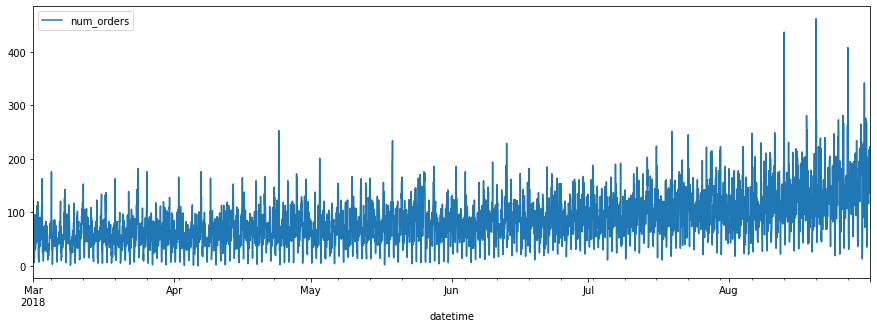

In [ ]:
plt.rcParams["figure.figsize"] = (15, 5) #задаем размер графиков для всех последующих графиков
data.plot();

## Exploring

### Decomposition

**The data is not very suitable for reading and analysis in its original form.**

**The earliest date in our data is March 1, 2018, which fell on a Thursday (this information was found on the internet). It was also found that March 8 and 9, 2018, were weekends. To ensure objectivity, we will analyze the data for a week when there were no national holidays: March 26, 2018, to April 1, 2018.**

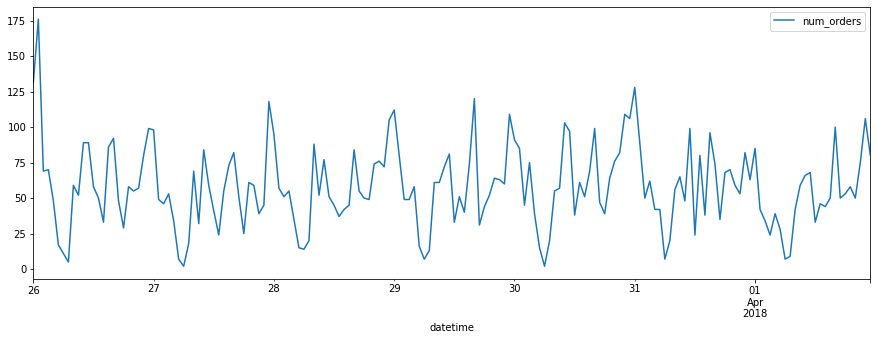

In [ ]:
data['2018-03-26':'2018-04-01'].plot();

**The cyclic nature of the data throughout the week and during the day is noticeable but not highly apparent.**

**For better analysis, we will decompose the raw data, meaning we will break down the original time series into three components: trend, seasonality, and residual. The residual is the component that cannot be explained by the trend and seasonality; it represents noise.**

**Let's examine the overall trend over the entire period by smoothing the line using a 720-hour moving average (24 hours * 30 days).**

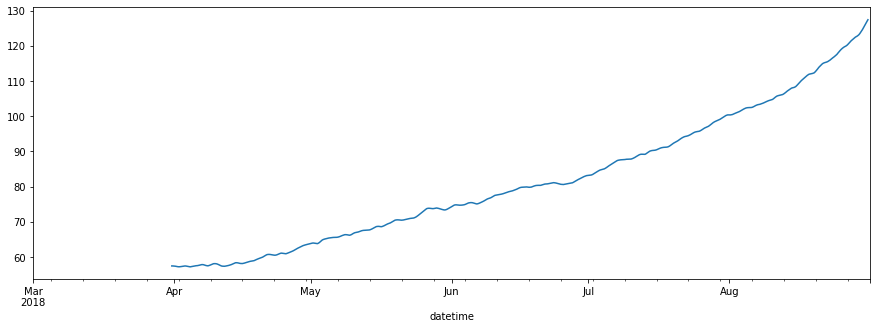

In [ ]:
decomposed = seasonal_decompose(data)
decomposed.trend.rolling(720).mean().plot();

**It's evident that there is a consistent increase in orders on average from month to month.**

**Now, let's take a look at the cyclical component.**

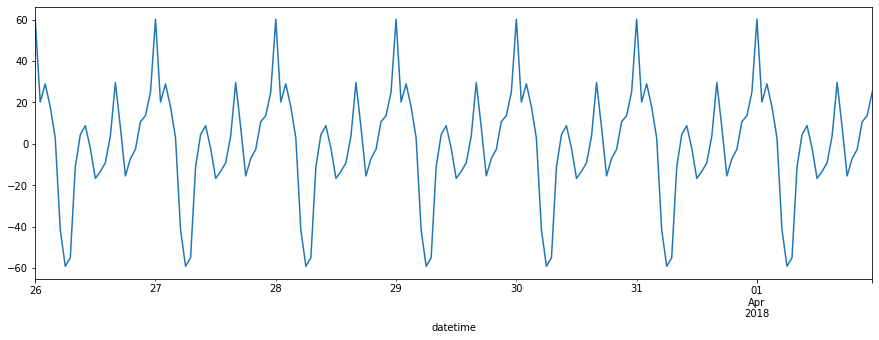

In [ ]:
decomposed.seasonal['2018-03-26':'2018-04-01'].plot(); # циклическая составляющая

**We can observe a distinctive recurring pattern from day to day. Consequently, there is cyclicality at the hourly level within each day, and a pronounced daily pattern is evident.**

**Let's take a closer look at the daily patterns.**

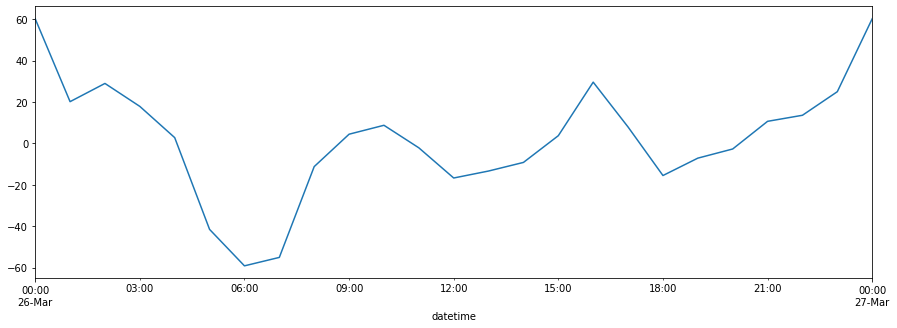

In [ ]:
decomposed.seasonal['2018-03-26 00:00:00':'2018-03-27 00:00:00'].plot();

**Throughout the day, cyclicality is well visible - from late night until 6 in the morning, orders sharply drop to a minimum, then they begin to rise again until the start of the working day. After a slight dip until 12 o'clock, there's a growth in orders until 4 PM. Then there's another small dip until 6 PM, followed by the end of the workday and a rise in orders until the night. This pattern repeats. In other words, there is a trend that correlates with a typical working day.**

**Let's see if there is weekly cyclicality. To do this, we will decompose the data resampled by 1 day and examine the cyclicality over 4 weeks when there were no national holidays.**

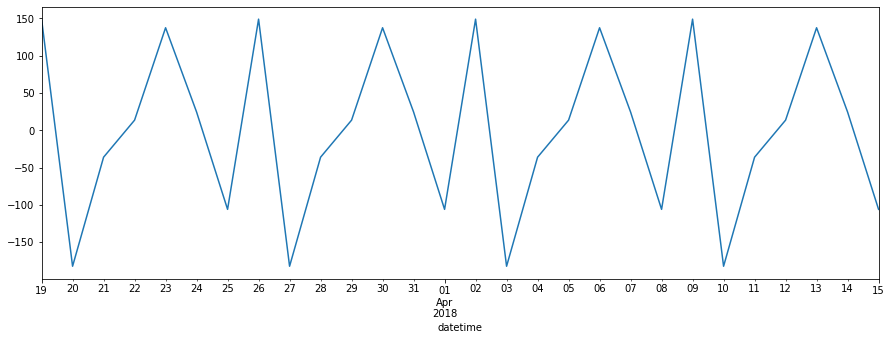

In [ ]:
seasonal_decompose(data.resample('1D').sum()).seasonal['2018-03-19':'2018-04-15'].plot();

**We can see a characteristic weekly cyclicality in orders:**

- A peak from Sunday night to Monday;
- Then a decrease from the peak (Sunday night to Monday) to a minimum (Monday night to Tuesday);
- Followed by a gradual increase from the minimum (Monday night to Tuesday) to a peak (Thursday night to Friday), with changes (reductions) in growth during Wednesday;
- From the peak (Thursday night to Friday), there's a decline to the second lowest point (Saturday night to Sunday);
- Then, a rise from the second lowest point (Saturday night to Sunday) to another peak (Sunday night to Monday).

### Creating Additional Features

**To make forecasts, it is necessary to create additional features:**

- Calendar features (month, day, day of the week, hour);

- "Lagged values" (lagging by different numbers of hours);

- Rolling mean (calculating the rolling mean should not include the current value of the series to prevent the target feature from "leaking" into the features).

Let's write a function that creates these additional features.

In [ ]:
def make_features(data, lags_list, rolling_mean_size): #max_lag - макс. размер отставания
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in lags_list:
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size, closed='left').mean()

make_features(data, [1,2,3,23,24,25], 24) #rolling_mean_size = 24, т.к. это имеем дело с числом заказов такси
data = data.dropna() #удалим пропуски, которые получаются в следствие создания лагов (пред. период недоступен)
data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,71.0,85.0,124.0,55.416667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,66.0,71.0,85.0,56.875000
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,43.0,66.0,71.0,57.041667
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,6.0,43.0,66.0,56.958333
2018-03-02 05:00:00,11,3,2,4,5,20.0,64.0,75.0,12.0,6.0,43.0,56.000000


In [ ]:
print('hour_min_value = ', data['hour'].min())
print('hour_max_value = ', data['hour'].max())

hour_min_value =  0
hour_max_value =  23


In [ ]:
print('day_min_value = ', data['day'].min())
print('day_max_value = ', data['day'].max())

day_min_value =  1
day_max_value =  31


In [ ]:
print('dayofweek_min_value = ', data['dayofweek'].min())
print('dayofweek_max_value = ', data['dayofweek'].max())

dayofweek_min_value =  0
dayofweek_max_value =  6


In [ ]:
print('month_min_value = ', data['month'].min())
print('month_max_value = ', data['month'].max())

month_min_value =  3
month_max_value =  8


## Training

### Data Splitting

**We will split our original dataset into training and testing sets. We won't create a separate validation set since we will use GridSearchCV with cross-validation. Since we are dealing with time series, the data split will be performed without shuffling. In GridSearchCV, we will split into folds using TimeSeriesSplit.**

**We will use two models - decision tree regression and LightGBM with different hyperparameters.**

**As our data includes categorical features, we need to encode them for use with simple models. We will use cyclic encoding through sine and cosine functions, as found on the internet. Since day, hour, month, and date cycle cyclically, we will encode them accordingly. For LightGBM, there is no need to encode features separately.**

In [ ]:
#function that encodes cyclic features
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

#encode the feature related to the month.
data = encode(data, 'month', 12)

#encode the feature related to the day of the month
data = encode(data, 'day', 31)

#encode the feature related to the day of the week.
data = encode(data, 'dayofweek', 7)

#encode the feature related to the hour.
data = encode(data, 'hour', 24)

#split the original dataset into features and the target feature
target = data['num_orders']
features = data.drop(['num_orders', 'month', 'day', 'dayofweek', 'hour'], axis=1)

display(features.info())
target.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4391 entries, 2018-03-02 01:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lag_1          4391 non-null   float64
 1   lag_2          4391 non-null   float64
 2   lag_3          4391 non-null   float64
 3   lag_23         4391 non-null   float64
 4   lag_24         4391 non-null   float64
 5   lag_25         4391 non-null   float64
 6   rolling_mean   4391 non-null   float64
 7   month_sin      4391 non-null   float64
 8   month_cos      4391 non-null   float64
 9   day_sin        4391 non-null   float64
 10  day_cos        4391 non-null   float64
 11  dayofweek_sin  4391 non-null   float64
 12  dayofweek_cos  4391 non-null   float64
 13  hour_sin       4391 non-null   float64
 14  hour_cos       4391 non-null   float64
dtypes: float64(15)
memory usage: 548.9 KB


None

(4391,)

In [ ]:
#split the features and target features into training and testing sets with a 90/10 ratio.
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=1)

#After encoding, all features are numeric, so no additional actions are required for the datasets to be used with tree-based models.

#Time series split for use in GridSearchCV
tcv = TimeSeriesSplit(n_splits=5)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3951, 15)
(440, 15)
(3951,)
(440,)


In [ ]:
model_tree = DecisionTreeRegressor(random_state=1)

param_tree = {'max_depth':range(1,10,2),
              'criterion':['friedman_mse'],
              'min_samples_split':range(2,10,2),
              'max_depth': range(1,10,2)}
gridsearch_tree = GridSearchCV(
    estimator=model_tree,
    param_grid=param_tree,
    scoring='neg_root_mean_squared_error',
    cv=tcv,
    n_jobs=-1)
gridsearch_tree.fit(features_train, target_train)
#The metric in GridSearchCV is negative RMSE, so to obtain RMSE, we need to multiply it by -1.

tree_rmse_train = round((-1 * gridsearch_tree.best_score_), 3)
tree_fit_time_train = round(
    pd.DataFrame(gridsearch_tree.cv_results_).iloc[gridsearch_tree.best_index_]['mean_fit_time'], 3)
print('The best RMSE value for the DecTreeReg model on the training set is =', tree_rmse_train)
print('The training time for the DecTreeReg model with the best score on the training set is =', tree_fit_time_train)

Лучшее значение метрики RMSE для модели DecTreeReg на тренировочной выборке = 28.445
Время обучения модели DecTreeReg с лучшим score на тренировочной выборке = 0.008


In [ ]:
model_lgb = lgb.LGBMRegressor(random_state=1)

param_lgb = {'learning_rate': [0.1, 0.05, 0.01],
             'n_estimators': [50, 100, 200]}
gridsearch_lgb = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_lgb,
    scoring='neg_root_mean_squared_error',
    cv=tcv,
    n_jobs=-1)
gridsearch_lgb.fit(features_train, target_train)
#метрика в gridsearchCV - отрицательное значение RMSE, чтобы получить RMSE необходимо умножить на -1

lgb_rmse_train = round(-1 * gridsearch_lgb.best_score_, 3)
lgb_fit_time_train = round(
    pd.DataFrame(gridsearch_lgb.cv_results_).iloc[gridsearch_lgb.best_index_]['mean_fit_time'], 3)
print('The best RMSE value for the LGBM model on the training set is =', lgb_rmse_train)
print('The training time for the LGBM model with the best score on the training set is ', lgb_fit_time_train)

Лучшее значение метрики RMSE для модели LGBM на тренировочной выборке = 24.694
Время обучения модели LGBM с лучшим score на тренировочной выборке = 0.738


## Testing

**The best RMSE value was achieved by the LGBM model, while the decision tree regression model showed the best training time.**

**Now, let's test the best-performing model, LGBM, on the test dataset.**

In [ ]:
start_predict_lgb = time.time()
predict_lgb = gridsearch_lgb.best_estimator_.predict(features_test)
end_predict_lgb = time.time()
print('RMSE for LGBM on the test set is =',
          round(mean_squared_error(target_test, predict_lgb, squared=False),3))
print('he prediction time of LGBM on the test dataset is =',
          round(end_predict_lgb - start_predict_lgb, 3))

RMSE для LGBM на тестовой выборке = 41.903
Время предсказания LGBM на тестовой выборке = 0.009


## Model Adequacy Check

**We will check the selected models for adequacy using the Dummy Model from the sklearn class, after importing it in the first step.**

**The check involves ensuring that the quality of the trained model selected above is better than the quality of the Dummy model, which makes predictions without relying on the features of the training set.**

In [ ]:
model_dummy = DummyRegressor()
parameters_dummy = {'strategy':['mean', 'median', 'constant'],
                            'constant':(0,300,10)}
gridsearch_dummy = GridSearchCV(
    estimator=model_dummy,
    param_grid=parameters_dummy,
    scoring='neg_root_mean_squared_error',
    cv=tcv,
    n_jobs=-1)
gridsearch_dummy.fit(features_train, target_train)
print('The best RMSE value for the Dummy model on the training set is =',
      round((-1 * gridsearch_dummy.best_score_), 3))

Лучшее значение метрики RMSE для Dummy-модели на тренировочной выборке = 40.54


In [ ]:
predict_dummy = gridsearch_dummy.best_estimator_.predict(features_test)
print('The best RMSE value for the Dummy model on the test set is =',
      round(mean_squared_error(target_test, predict_dummy, squared=False), 3))

Лучшее значение метрики RMSE для Dummy-модели на тестовой выборке = 84.69


**CONCLUSION**

**In the end, the Dummy model was able to achieve the best model quality with an RMSE of 84.69 on the test dataset, which is significantly lower than the best results of the selected and trained decision tree regression and LightGBM models. This demonstrates the adequacy of the model we have found and chosen.**

## General Conclusion

**We examined a time series from March to August 2018 with information about the number of taxi orders made. We discovered patterns in the data related to cyclicality. We tested several models for the task of forecasting the number of taxi orders for the next hour.**

**Out of the two models we selected (decision tree regression and LightGBM), the second model, LGBM, performed better in this task in terms of the RMSE metric. Using the LightGBM model, we achieved an RMSE value of 41.903 on the test dataset, which satisfies the initial requirement to obtain an RMSE value below 48.**